# Regresión Logistica en PYSPARK 

Aplicamos la regresion logistica a la data newdatapandas que es el 4% de la la data train e la cual presanta las variables

    root
- fare_amount: double (nullable = true)
- pickup_longitude: double (nullable = true)
- pickup_latitude: double (nullable = true)
- dropoff_longitude: double (nullable = true)
- dropoff_latitude: double (nullable = true)
- distancia: double (nullable = true)
- dia_semana: double (nullable = true)
- hora: double (nullable = true)
- passenger: string (nullable = true

primero importaremos las librerias de spark
y para poder iniciar sesion
 

In [2]:
import findspark
#findspark.init("/usr/local/spark/spark-3.1.1-bin-hadoop2.7")    #para linux
findspark.init()    

In [3]:
# importamos pyspark
from pyspark import SparkConf, SparkContext
# Variable de configuración
conf = SparkConf().setMaster("local[*]").setAppName("ModeloML").set("spark.driver.maxResultSize", "0")

# iniciamos un contexto spark (solo se ejecuta uno. Para ejecutar otra vez , reiniciar el kernel)
sc = SparkContext(conf = conf)
sc

<SparkContext master=local[*] appName=ModeloML>

In [6]:
from pyspark.sql import SparkSession

In [166]:
from pyspark.sql.types import StringType
from pyspark import SQLContext
# le pasamos el contexto anterior
sqlContext = SQLContext(sc)
dfspark = sqlContext.read.format('csv').option("header","true").option("inferSchema","true").load('newDatapandas.csv')

In [167]:
dfspark.show(5)

+-----------+--------------------+-----------------+-----------------+------------------+------------------+---------------+--------------------+--------------------+---------+----------+----+
|fare_amount|     pickup_datetime| pickup_longitude|  pickup_latitude| dropoff_longitude|  dropoff_latitude|passenger_count|        dif_latitude|       dif_longitude|distancia|dia_semana|hora|
+-----------+--------------------+-----------------+-----------------+------------------+------------------+---------------+--------------------+--------------------+---------+----------+----+
|        8.0|2015-03-12 23:14:...|-73.9931411743164|40.72793960571289|-73.99661254882812|40.744529724121094|              2|0.016590118408203125| 0.00347137451171875|1.8683056|         4|  23|
|       10.0|2013-08-21 08:38:...|       -73.964837|        40.769933|        -73.983462|         40.761655|              1|0.008278000000004226|0.018625000000000114|1.8191968|         3|   8|
|        5.5|2014-01-23 18:40:...| 

Verificamos nuestros datos ahora nuestra variable de evaluacion es la variable `passenger_count` por lo tanto usamos la funcion `printShema pára ver que tipo de dato es

In [168]:
dfspark.printSchema()

root
 |-- fare_amount: double (nullable = true)
 |-- pickup_datetime: string (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- dif_latitude: double (nullable = true)
 |-- dif_longitude: double (nullable = true)
 |-- distancia: double (nullable = true)
 |-- dia_semana: integer (nullable = true)
 |-- hora: integer (nullable = true)



In [169]:
list(dfspark.columns)

['fare_amount',
 'pickup_datetime',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'passenger_count',
 'dif_latitude',
 'dif_longitude',
 'distancia',
 'dia_semana',
 'hora']

Seleccionamos solo los datos que usaremos y lo convertimos a un tipo double

In [170]:
from pyspark.sql import functions as F
#casteamos todas las variables a double

lista_columnas_admisibles = ['fare_amount','passenger_count','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','distancia','dia_semana','hora']
dfspark = dfspark.select(*(F.col(c).cast('double').alias(c) for c in lista_columnas_admisibles))

Verificamos nuestros datos nuevamente

In [171]:
dfspark.printSchema()


root
 |-- fare_amount: double (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- distancia: double (nullable = true)
 |-- dia_semana: double (nullable = true)
 |-- hora: double (nullable = true)



In [172]:
dfspark.show(5)

+-----------+---------------+-----------------+-----------------+------------------+------------------+---------+----------+----+
|fare_amount|passenger_count| pickup_longitude|  pickup_latitude| dropoff_longitude|  dropoff_latitude|distancia|dia_semana|hora|
+-----------+---------------+-----------------+-----------------+------------------+------------------+---------+----------+----+
|        8.0|            2.0|-73.9931411743164|40.72793960571289|-73.99661254882812|40.744529724121094|1.8683056|       4.0|23.0|
|       10.0|            1.0|       -73.964837|        40.769933|        -73.983462|         40.761655|1.8191968|       3.0| 8.0|
|        5.5|            1.0|       -74.001017|        40.746352|        -73.990873|         40.739497| 1.145462|       4.0|18.0|
|        6.1|            1.0|       -73.982433|        40.768137|        -73.989684|         40.776138|1.0793539|       6.0|14.0|
|        5.0|            1.0|       -73.990358|        40.740377|         -74.00085|      

Ahora creamos una funcion para poder darle etiquetas a los datos de estudio y porder clasificarlas 

In [173]:
def string_to_float(x):
    return float(x)

def condicion(r):
    if (1.0<= r<=3.0):
        label =" Pocos pasajeros"
    elif (3.0< r<= 5.0):
        label = "Normal Pasajeros"
    else:
        label = "Muchos pasajeros"
    return label
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, DoubleType


string_to_float_udf = udf(string_to_float, DoubleType())
class_udf =udf(lambda x: condicion(x),StringType())
dfspark = dfspark.withColumn("passenger",class_udf(dfspark['passenger_count']))


In [174]:
from pyspark.sql.functions import udf, array, col

In [177]:
dfspark = dfspark.drop("passenger_count")

Verificamosa nuevamente nuestra data que haya agregaso la columna y eliminamos los dataos que los etiquetamos

In [178]:
dfspark.printSchema()

root
 |-- fare_amount: double (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- distancia: double (nullable = true)
 |-- dia_semana: double (nullable = true)
 |-- hora: double (nullable = true)
 |-- passenger: string (nullable = true)



Primero crearemos nuestro stringIndexer a donde agregaremos nuestros valores numericas a  ciertas variables que estan en string
despues crreamos nuestro `pipeline` que es un especie de constructor para utilizar diversas funciones
y utilizamos nuestras entradas de columnas y como van a salir.


In [182]:
def get_dummy(dfspark, indexcol, categoricalCols,continuousCols,labelsCol):
    from pyspark.ml import Pipeline
    from pyspark.ml.feacture import StringIndexer, OneHotEncoder,VectorAssembler
    from pyspark.sql.functions import col
    
    #indexar las variables en String
    indexers =[StringIndexer(inputCol = c,outputCol ="{0}_indexed".format(c))for c in categoricalCols]
    #vamos a encodificar esta variables en string
    encoders = [OneHotEncoder(inputCol= indexer.getOutputCol(),
                              outputCol ="{0}_encoded".format(indexer.getOutputCol()))for indexer in indexers]

    # convertimos nuestras variables de entrada en un vector denso
    assembler = VectorAssembler(inputCols =[encoder.getOutputCol()for encoder in encoders]+continuousCols, 
                                          outputCol ="features")
    # añadimos a pipeline
    pipeline = Pipeline(stages=indexers + encoders +[assembler])#nos indiac un solo vector
    # entrenaremos  la data
    model= pipeline.fit(dfspark)
    
    data = model.transform(dfspark)
    data = data.withColmn('label',col(labelCol))
    
    return data.select(indexCol,'features','label')
# crearemos las etiquetas de las columnas label nuestra variable salida y feature nuestras variables de entreda
    

In [183]:
from pyspark.ml.linalg import Vectors
from pyspark.ml import Pipeline
from pyspark.ml.feature import IndexToString,StringIndexer,VectorIndexer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
# con esta funcion mostramos la data en u dataframe
def transData(data):
    return data.rdd.map(lambda r :[Vectors.dense(r[:-1]),r[-1]]).toDF(['features','label'])



In [186]:
transformed = transData(dfspark)
# cpomo se muestra que cada solumna de variable de entreda se convertieron en un solo dato vector
# u la variable de salida se convierte en un label
transformed.show(10,False)

+--------------------------------------------------------------------------------------------------+----------------+
|features                                                                                          |label           |
+--------------------------------------------------------------------------------------------------+----------------+
|[8.0,-73.9931411743164,40.72793960571289,-73.99661254882812,40.744529724121094,1.8683056,4.0,23.0]| Pocos pasajeros|
|[10.0,-73.964837,40.769933,-73.983462,40.761655,1.8191968,3.0,8.0]                                | Pocos pasajeros|
|[5.5,-74.001017,40.746352,-73.990873,40.739497,1.145462,4.0,18.0]                                 | Pocos pasajeros|
|[6.1,-73.982433,40.768137,-73.989684,40.776138,1.0793539,6.0,14.0]                                | Pocos pasajeros|
|[5.0,-73.990358,40.740377,-74.00085,40.733955,1.1367035,7.0,23.0]                                 | Pocos pasajeros|
|[5.7,-73.990648,40.763472,-73.976782,40.78257,2.424119,

In [ ]:
#crearemos un nuevos String iodexer
#nuevamente iniciaremos el mismo proceso

In [188]:
labelIndexer = StringIndexer(inputCol ='label',outputCol ='indexedLabel').fit(transformed)
labelIndexer.transform(transformed).show(10,True)

+--------------------+----------------+------------+
|            features|           label|indexedLabel|
+--------------------+----------------+------------+
|[8.0,-73.99314117...| Pocos pasajeros|         0.0|
|[10.0,-73.964837,...| Pocos pasajeros|         0.0|
|[5.5,-74.001017,4...| Pocos pasajeros|         0.0|
|[6.1,-73.982433,4...| Pocos pasajeros|         0.0|
|[5.0,-73.990358,4...| Pocos pasajeros|         0.0|
|[5.7,-73.990648,4...|Normal Pasajeros|         1.0|
|[10.2,-73.981319,...| Pocos pasajeros|         0.0|
|[4.9,-73.991235,4...| Pocos pasajeros|         0.0|
|[22.1,-73.948315,...| Pocos pasajeros|         0.0|
|[9.3,-73.989308,4...| Pocos pasajeros|         0.0|
+--------------------+----------------+------------+
only showing top 10 rows



In [192]:
#hacemos un uevo tratamenitneop de datos para volver a metre nuetrso datos de entrada en un vector para aplicarlo a la regresion logistica
featureIndexer = VectorIndexer(inputCol ='features',outputCol ='indexedFeatures',maxCategories =4).fit(transformed)
featureIndexer.transform(transformed).show(5,True)

+--------------------+----------------+--------------------+
|            features|           label|     indexedFeatures|
+--------------------+----------------+--------------------+
|[8.0,-73.99314117...| Pocos pasajeros|[8.0,-73.99314117...|
|[10.0,-73.964837,...| Pocos pasajeros|[10.0,-73.964837,...|
|[5.5,-74.001017,4...| Pocos pasajeros|[5.5,-74.001017,4...|
|[6.1,-73.982433,4...| Pocos pasajeros|[6.1,-73.982433,4...|
|[5.0,-73.990358,4...| Pocos pasajeros|[5.0,-73.990358,4...|
+--------------------+----------------+--------------------+
only showing top 5 rows



### TERMINAMOS EL TRATAMIENTO DE LA DATA PARA APLICAR LA REGRESION LOGISTICA

In [193]:

# dividimos nuestra data en dat de entrenamiento y testeo 60% de entrenamiento de manera aleatoria y el 40% a la data de testeo
(X_train, x_test) = transformed.randomSplit([0.6,0.4])
X_train.show(5,False)
x_test.show(5,False)

Exception ignored in: <function JavaWrapper.__del__ at 0x000001FFDE3D0D30>
Traceback (most recent call last):
  File "C:\spark-3.1.2-bin-hadoop3.2\spark-3.1.2-bin-hadoop3.2\python\pyspark\ml\wrapper.py", line 39, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
AttributeError: 'VectorIndexer' object has no attribute '_java_obj'


+--------------------------------------------------------------------------------------------------+----------------+
|features                                                                                          |label           |
+--------------------------------------------------------------------------------------------------+----------------+
|[0.0,-74.06729888916016,40.702171325683594,-74.07487487792969,40.6984748840332,0.7597047,5.0,4.0] | Pocos pasajeros|
|[0.0,-73.9375991821289,40.7584228515625,-73.93760681152344,40.75836944580078,0.0059748,5.0,3.0]   | Pocos pasajeros|
|[0.0,-73.93758,40.758127,-73.937583,40.758137,0.0011406192,3.0,11.0]                              | Pocos pasajeros|
|[0.01,-74.02980041503906,40.75298309326172,-74.02978515625,40.75297546386719,0.0015404668,4.0,1.0]| Pocos pasajeros|
|[0.01,-73.96696472167969,40.76126480102539,-73.58683776855469,41.03192901611328,43.90549,4.0,3.0] | Pocos pasajeros|
+-------------------------------------------------------

### AHORA CREAREMOS NUESTRO MODELO DE REGRESION lOGISTICA

In [195]:
# crearemos nuestro modelo de regresion logistica
from pyspark.ml.classification import LogisticRegression
logr = LogisticRegression(featuresCol ='indexedFeatures', labelCol ='indexedLabel')

In [196]:
#devolvemos la nuestra variable numerica a la clase en que pertenecia

labelConverter = IndexToString(inputCol = "prediction",outputCol ="predictedLabel",labels =labelIndexer.labels)

In [200]:
#labelIndexer = variable de categoria
#feactureIndexer= vector donde esta todas nuestras variables de entreda
# labelConverter variables de prediccion convertidas en su label original
# logr que es el modelo de regresion logistica
pipeline =Pipeline(stages =[labelIndexer,featureIndexer,logr,labelConverter])


In [201]:
# procedemos a netrenar
model = pipeline.fit(X_train)

Exception ignored in: <function JavaWrapper.__del__ at 0x000001FFDE3D0D30>
Traceback (most recent call last):
  File "C:\spark-3.1.2-bin-hadoop3.2\spark-3.1.2-bin-hadoop3.2\python\pyspark\ml\wrapper.py", line 39, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
AttributeError: 'LogisticRegression' object has no attribute '_java_obj'


In [204]:
# verificamos la prediccion
predictions = model.transform(x_test)
#datos de entreda |||lebel: dato real ||| predictedlabel  dato de prediccion
predictions.select("features","label","predictedLabel").show(50)

+--------------------+----------------+----------------+
|            features|           label|  predictedLabel|
+--------------------+----------------+----------------+
|[0.0,-74.009997,4...| Pocos pasajeros| Pocos pasajeros|
|[0.0,-73.78771972...| Pocos pasajeros| Pocos pasajeros|
|[0.01,-73.981872,...| Pocos pasajeros| Pocos pasajeros|
|[1.9,-73.93776702...| Pocos pasajeros| Pocos pasajeros|
|[2.5,-75.32923571...| Pocos pasajeros| Pocos pasajeros|
|[2.5,-74.070413,4...| Pocos pasajeros| Pocos pasajeros|
|[2.5,-74.025002,4...| Pocos pasajeros| Pocos pasajeros|
|[2.5,-74.016172,4...| Pocos pasajeros| Pocos pasajeros|
|[2.5,-74.013349,4...| Pocos pasajeros| Pocos pasajeros|
|[2.5,-74.012193,4...| Pocos pasajeros| Pocos pasajeros|
|[2.5,-74.011313,4...| Pocos pasajeros| Pocos pasajeros|
|[2.5,-74.00861,40...| Pocos pasajeros| Pocos pasajeros|
|[2.5,-74.008482,4...| Pocos pasajeros| Pocos pasajeros|
|[2.5,-74.008252,4...| Pocos pasajeros| Pocos pasajeros|
|[2.5,-74.008175,4...|Muchos pa

### Para saber nuestra tasa de aprendizaje  de nuestro modelo 

In [208]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol ="indexedLabel",predictionCol ="prediction",metricName ="accuracy")
acuracy = evaluator.evaluate(predictions)


In [209]:
print("Precisión = %g  "%(acuracy))
print("Test error = %g" %(1.0-acuracy))

Precisión = 0.883267  
Test error = 0.116733


In [217]:

# haremos nuestro ploteo y veremos en una matriz de confucion una matrix normalizada y una sin normalizar
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matriz(cm,classes,normalize = False, title ='Confusion matrix',cmap = plt.cm.Blues):
    if normalize:
        cm =cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
        print("Matriz normalizada de confusion")
    else:
        print("Matriz de confusion sin normalizacion")
            
    print(cm)
    plt.imshow(cm,interpolation='nearest',cmap =cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation =45)
    plt.yticks(tick_marks,classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max()/2.
    for i , j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,format(cm[i,j],fmt),
        horizontalalignment ="center",
        color ="white" if cm[i,j]> thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('predicted label')

In [213]:
class_temp =predictions.select ('label').groupBy('label').count().sort('count',ascending = False).toPandas()
class_temp = class_temp['label'].values.tolist()
class_names = map(str,class_temp)
class_temp

[' Pocos pasajeros', 'Normal Pasajeros', 'Muchos pasajeros']

In [214]:

#usaremo sklearn para omostrar nuestra matriz de confucion
from sklearn.metrics import confusion_matrix
y_true = predictions.select('label')
y_true = y_true.toPandas()
y_pred = predictions.select('predictedLabel')
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true,y_pred,labels =class_temp)
cnf_matrix

array([[784066,      0,      1],
       [ 81712,      0,      0],
       [ 21910,      0,      0]], dtype=int64)

Matriz de confusion sin normalizacion
[[784066      0      1]
 [ 81712      0      0]
 [ 21910      0      0]]


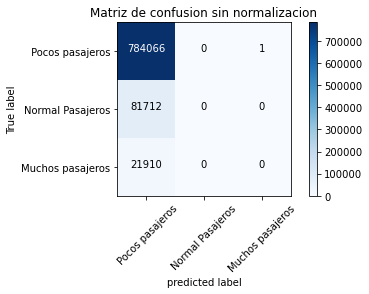

In [218]:
plt.figure()
plot_confusion_matriz(cnf_matrix,classes =class_temp,title='Matriz de confusion sin normalizacion')
plt.show()

Matriz normalizada de confusion
[[9.99998725e-01 0.00000000e+00 1.27540121e-06]
 [1.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.00000000e+00 0.00000000e+00 0.00000000e+00]]


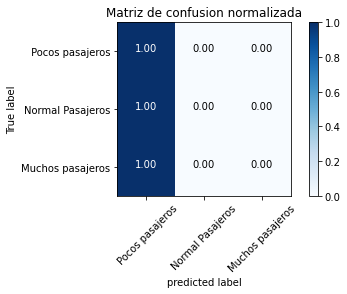

In [220]:
plt.figure()
plot_confusion_matriz(cnf_matrix,classes =class_temp,normalize = True, title='Matriz de confusion normalizada')
plt.show()